In [24]:
import string
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.layers import TextVectorization
import tensorflow as tf

seed = 168

In [2]:
print(f"GPU is available: {tf.test.is_gpu_available()}")

GPU is available: True


## 1. Problem Description

In this project, we will use the Kaggle Diaster Tweets dataset to build a Deep Learning model to classify tweets. In specific, we need to predict whether a given tweet is about a real disaster or not. This is a binary classification problem for NLP use cases. We will use a RNN family neural network for the text classification task.

There are two datasets, training and testing sets. The training set has several columns such as keyword, location and text for the prediction of target, but we'll only be using the texgt to make the prediction for this project. There are around 7.6K and 3.3K rows in the two datasets respectively. 

## 2. EDA

In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
df_train.shape, df_test.shape

((7613, 5), (3263, 4))

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<Axes: >

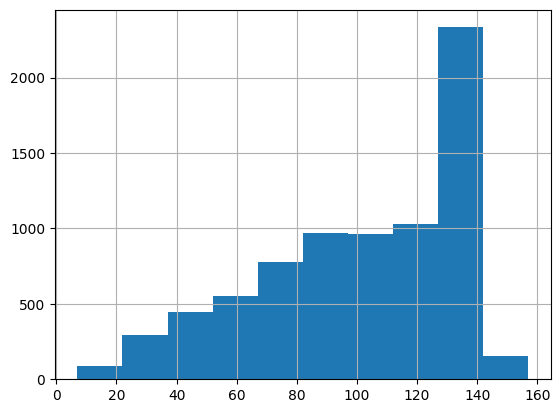

In [9]:
# Check text length by characters
df_train.text.apply(lambda x: len(x)).hist()

<Axes: >

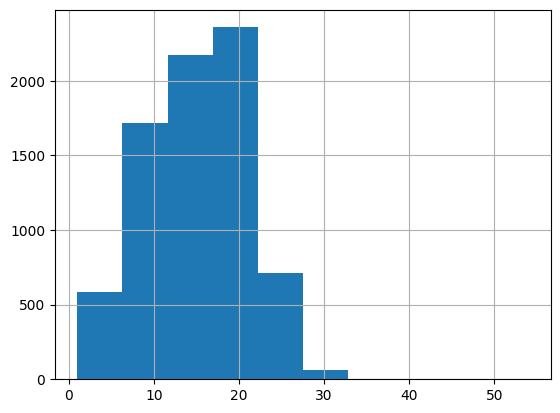

In [10]:
# Check text length by words and punctuations
df_train.text.str.split(' ').apply(lambda x: len(x)).hist()

In [11]:
# Check the number of unique words, i.e. size of vocab
unique_words = set()
df_train.text.str.split(' ').apply(lambda x: unique_words.update(x))
unique_words.remove('')
len(unique_words)

32016

In [12]:
df_train.target.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

We can see the data is in good shape - there are no missing values in the text and target columns and data types are correct. The most common tween length is around 130 characters, and 20 words which means we don't need a neural network with gigantic capcity to process the data. Also, the vacabulary size is around 32K (including punctuations). The dataset is nearly balanced with roughly same amount of samples in each class.

## 3. Model Architecture

First, let's create a TF dataset. Then we'll build a basic LSTM based RNN model that tranforms words into embeddings and use an LSTM layer and dense layer to learn and predict the text classes.

In [13]:
# Shuffle the data and drop un-needed columns
df_train = df_train.sample(frac=1, random_state=seed)
df_train.drop(["id", "keyword", "location"], axis=1, inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_train.head()

,text,target
0,Damn that sinkhole on sunset????,1
1,Migrants Rescued After Boat Capsizes Off Libya...,1
2,@randerson62 Watching news of wild fires and h...,1
3,Reddit Will Now Quarantine Offensive Content h...,1
4,In #India 119000 people have taken shelter in ...,1


In [14]:
# Split into train and validation sets
df_trn, df_val = train_test_split(df_train, test_size=.1, random_state=seed)
df_trn.shape, df_val.shape

((6851, 2), (762, 2))

In [15]:
# Create TF datasets

def create_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["text"].to_numpy(), df["target"].to_numpy())
    )
    dataset = dataset.batch(100)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


trn_ds = create_dataset(df_trn)
val_ds = create_dataset(df_val)

In [ ]:
# Preprocess and vectorize the text data

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = trn_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [17]:
# Create the model

inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560128   
                                                                 
 bidirectional (Bidirection  (None, 500, 128)          98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                             

In [18]:
# Compile and train the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
epochs = 3
model.fit(trn_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3


I0000 00:00:1707188992.191282     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - 21s 166ms/step - loss: 0.5623 - accuracy: 0.6976 - val_loss: 0.4129 - val_accuracy: 0.8360
Epoch 2/3
69/69 [==============================] - 5s 72ms/step - loss: 0.2777 - accuracy: 0.8897 - val_loss: 0.4579 - val_accuracy: 0.8110
Epoch 3/3
69/69 [==============================] - 5s 73ms/step - loss: 0.1407 - accuracy: 0.9517 - val_loss: 0.5951 - val_accuracy: 0.7546


In [41]:
# Make predictions on the test set
test_ds = tf.data.Dataset.from_tensor_slices((df_test["text"].to_numpy()))
test_ds = test_ds.batch(100)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

In [44]:
df_test['target'] = predictions

In [48]:
submission = df_test[['id', 'target']]
submission.to_csv('submission.csv', index=False)

## 4. Results and Analysis

In [ ]:
epochs = 20

max_features = 20000
embedding_dim = 128
sequence_length = 500

First try training for more epochs and record the training history.

In [20]:
epochs = 20

inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["Accuracy", "AUC"])

history = model.fit(trn_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
69/69 [==============================] - 19s 168ms/step - loss: 0.5667 - Accuracy: 0.6916 - auc: 0.7570 - val_loss: 0.4257 - val_Accuracy: 0.8281 - val_auc: 0.8792
Epoch 2/20
69/69 [==============================] - 5s 74ms/step - loss: 0.2787 - Accuracy: 0.8895 - auc: 0.9471 - val_loss: 0.5019 - val_Accuracy: 0.7887 - val_auc: 0.8602
Epoch 3/20
69/69 [==============================] - 5s 76ms/step - loss: 0.1281 - Accuracy: 0.9553 - auc: 0.9862 - val_loss: 0.6138 - val_Accuracy: 0.7625 - val_auc: 0.8507
Epoch 4/20
69/69 [==============================] - 5s 74ms/step - loss: 0.1342 - Accuracy: 0.9577 - auc: 0.9798 - val_loss: 0.7006 - val_Accuracy: 0.7638 - val_auc: 0.8422
Epoch 5/20
69/69 [==============================] - 5s 75ms/step - loss: 0.0608 - Accuracy: 0.9829 - auc: 0.9949 - val_loss: 0.7267 - val_Accuracy: 0.7664 - val_auc: 0.8468
Epoch 6/20
69/69 [==============================] - 5s 75ms/step - loss: 0.0412 - Accuracy: 0.9910 - auc: 0.9959 - val_loss: 0.7325 -

In [23]:
history.history.keys()

dict_keys(['loss', 'Accuracy', 'auc', 'val_loss', 'val_Accuracy', 'val_auc'])

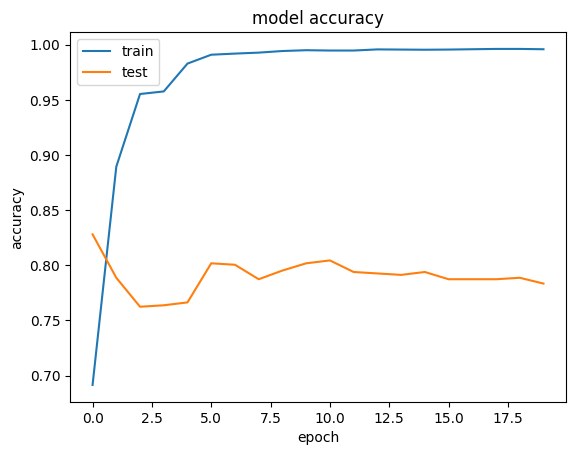

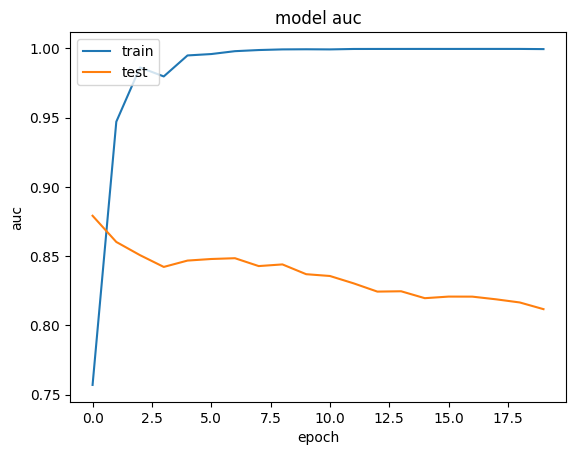

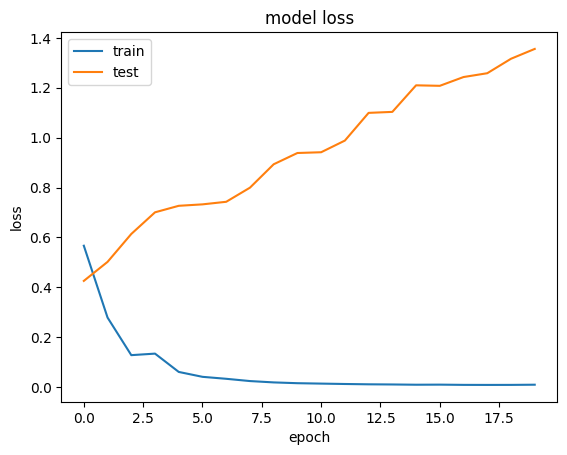

In [28]:
# Visualize training history

plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clearly, the model is overfitting. Let's add dropout to reduce it.

Epoch 1/20
69/69 [==============================] - 20s 172ms/step - loss: 0.5641 - Accuracy: 0.6927 - auc: 0.7609 - val_loss: 0.4074 - val_Accuracy: 0.8346 - val_auc: 0.8843
Epoch 2/20
69/69 [==============================] - 5s 78ms/step - loss: 0.2791 - Accuracy: 0.8888 - auc: 0.9467 - val_loss: 0.4451 - val_Accuracy: 0.8294 - val_auc: 0.8687
Epoch 3/20
69/69 [==============================] - 5s 78ms/step - loss: 0.1327 - Accuracy: 0.9539 - auc: 0.9853 - val_loss: 0.5537 - val_Accuracy: 0.7756 - val_auc: 0.8547
Epoch 4/20
69/69 [==============================] - 5s 79ms/step - loss: 0.0785 - Accuracy: 0.9761 - auc: 0.9936 - val_loss: 0.7009 - val_Accuracy: 0.7625 - val_auc: 0.8347
Epoch 5/20
69/69 [==============================] - 5s 79ms/step - loss: 0.0567 - Accuracy: 0.9816 - auc: 0.9963 - val_loss: 0.7387 - val_Accuracy: 0.7927 - val_auc: 0.8424
Epoch 6/20
69/69 [==============================] - 6s 80ms/step - loss: 0.0448 - Accuracy: 0.9869 - auc: 0.9973 - val_loss: 0.9303 -

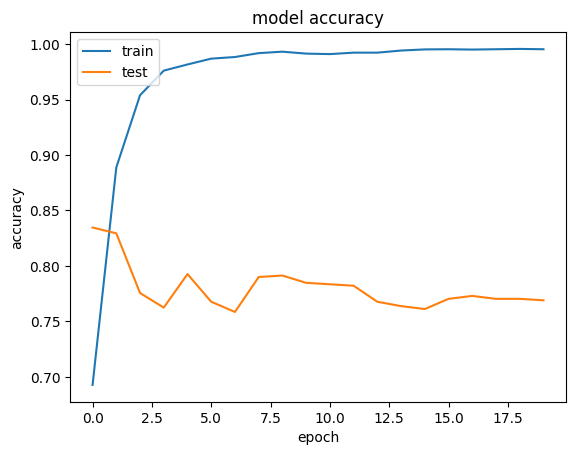

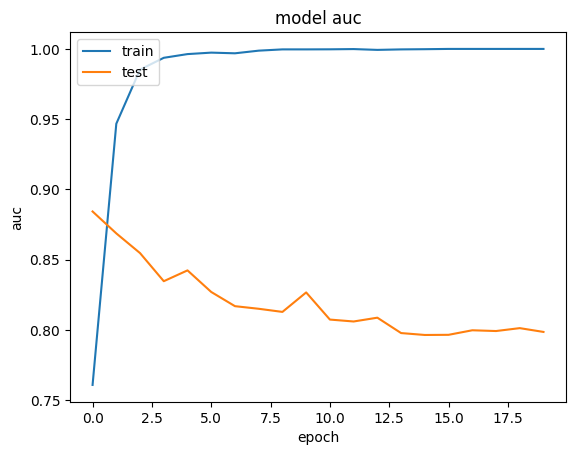

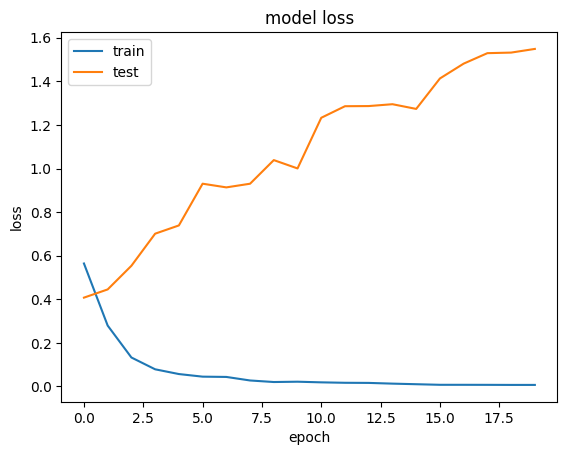

In [29]:
epochs = 20
dropout_rate = .1

inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(rate=dropout_rate)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(rate=dropout_rate)(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["Accuracy", "AUC"])

history = model.fit(trn_ds, validation_data=val_ds, epochs=epochs)

plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This doesn't seem to be helpful. Let's try reduce the number of LSTM cells to reduce the model's capacity to learn.

Epoch 1/20
69/69 [==============================] - 20s 180ms/step - loss: 0.5662 - Accuracy: 0.6967 - auc: 0.7602 - val_loss: 0.4227 - val_Accuracy: 0.8189 - val_auc: 0.8801
Epoch 2/20
69/69 [==============================] - 5s 71ms/step - loss: 0.2972 - Accuracy: 0.8816 - auc: 0.9397 - val_loss: 0.4428 - val_Accuracy: 0.8058 - val_auc: 0.8677
Epoch 3/20
69/69 [==============================] - 5s 71ms/step - loss: 0.1490 - Accuracy: 0.9498 - auc: 0.9831 - val_loss: 0.5357 - val_Accuracy: 0.7835 - val_auc: 0.8428
Epoch 4/20
69/69 [==============================] - 5s 71ms/step - loss: 0.0954 - Accuracy: 0.9712 - auc: 0.9908 - val_loss: 0.6507 - val_Accuracy: 0.7887 - val_auc: 0.8427
Epoch 5/20
69/69 [==============================] - 5s 72ms/step - loss: 0.0789 - Accuracy: 0.9759 - auc: 0.9937 - val_loss: 0.7099 - val_Accuracy: 0.8018 - val_auc: 0.8385
Epoch 6/20
69/69 [==============================] - 5s 72ms/step - loss: 0.0549 - Accuracy: 0.9829 - auc: 0.9966 - val_loss: 0.8096 -

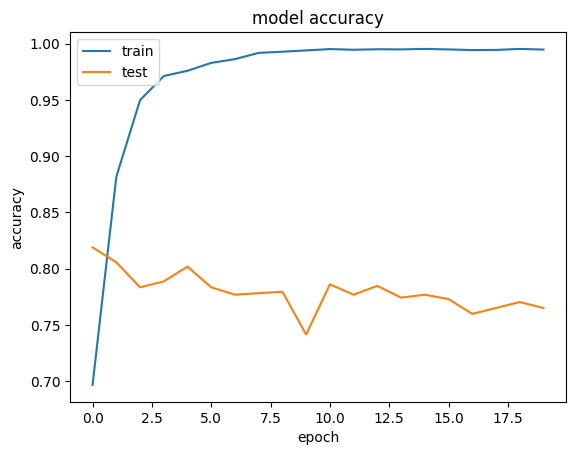

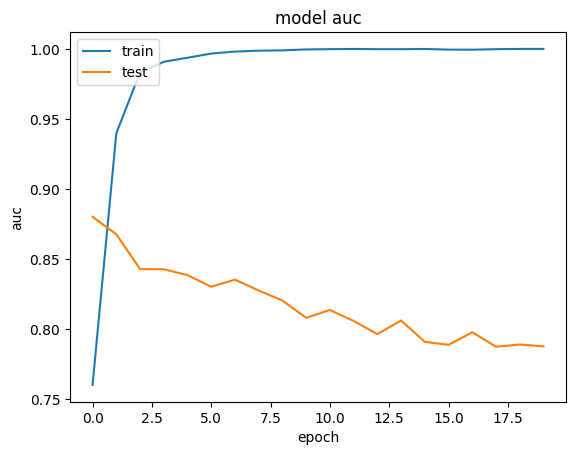

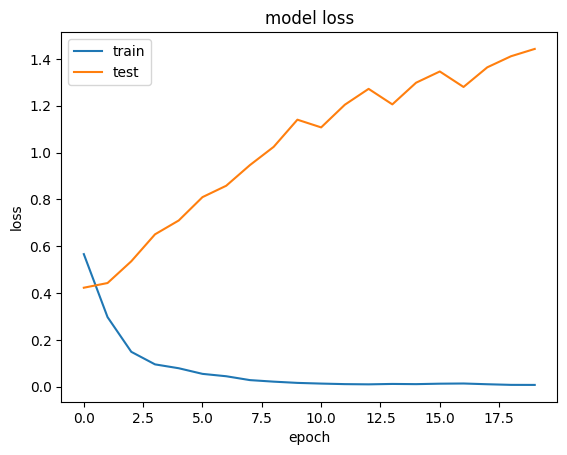

In [30]:
epochs = 20
dropout_rate = .1

inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(rate=dropout_rate)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(rate=dropout_rate)(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["Accuracy", "AUC"])

history = model.fit(trn_ds, validation_data=val_ds, epochs=epochs)

plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Finally, let's try changing the text parameters:

Epoch 1/20
69/69 [==============================] - 19s 167ms/step - loss: 0.5725 - Accuracy: 0.6906 - auc: 0.7570 - val_loss: 0.4257 - val_Accuracy: 0.8202 - val_auc: 0.8781
Epoch 2/20
69/69 [==============================] - 4s 59ms/step - loss: 0.3405 - Accuracy: 0.8629 - auc: 0.9210 - val_loss: 0.4430 - val_Accuracy: 0.8084 - val_auc: 0.8709
Epoch 3/20
69/69 [==============================] - 4s 59ms/step - loss: 0.2213 - Accuracy: 0.9218 - auc: 0.9639 - val_loss: 0.5127 - val_Accuracy: 0.7900 - val_auc: 0.8688
Epoch 4/20
69/69 [==============================] - 4s 59ms/step - loss: 0.1587 - Accuracy: 0.9495 - auc: 0.9760 - val_loss: 0.7307 - val_Accuracy: 0.7283 - val_auc: 0.8544
Epoch 5/20
69/69 [==============================] - 4s 59ms/step - loss: 0.1406 - Accuracy: 0.9562 - auc: 0.9814 - val_loss: 0.5561 - val_Accuracy: 0.8071 - val_auc: 0.8559
Epoch 6/20
69/69 [==============================] - 4s 61ms/step - loss: 0.1212 - Accuracy: 0.9642 - auc: 0.9862 - val_loss: 0.6068 -

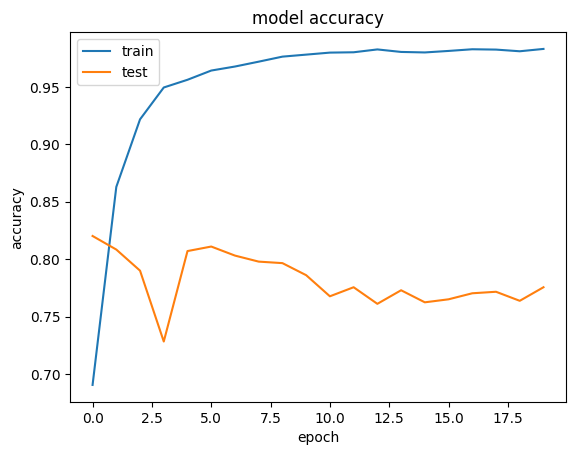

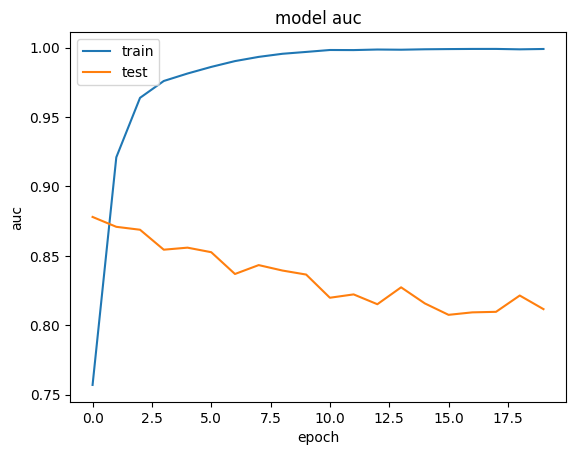

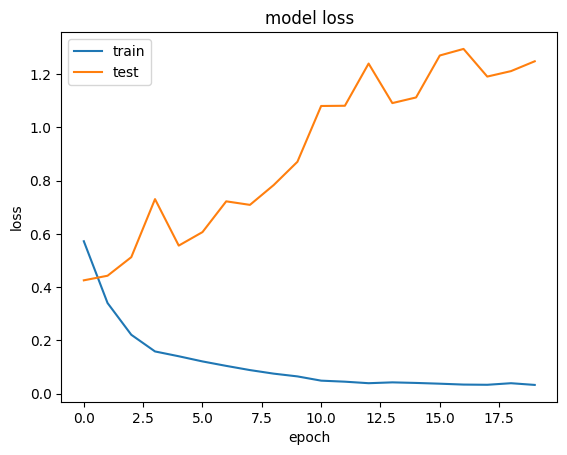

In [31]:
# Preprocess and vectorize the text data

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

max_features = 10000
embedding_dim = 128
sequence_length = 400

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = trn_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

epochs = 20
dropout_rate = .1

inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(rate=dropout_rate)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(rate=dropout_rate)(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["Accuracy", "AUC"])

history = model.fit(trn_ds, validation_data=val_ds, epochs=epochs)

plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5. Conclusion

It seems none of the measures helped to improve the model's performance. This is probably due to the fact that the model has a very large capacity. In the future, we can try training for fewer epochs, for example, do early stoping, also we can use a higher dropout rate.